The purpose of this notebook is to create the baseline model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
import metric_functions as mf

Using TensorFlow backend.


In [1]:
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras --user

     |████████████████████████████████| 378kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.3MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn --user

     |████████████████████████████████| 7.3MB 1.4MB/s eta 0:00:01     |███████████▉                    | 2.7MB 1.7MB/s eta 0:00:03
     |████████████████████████████████| 307kB 894kB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Compile and Create Data <a id='data'></a>

## Identify Working Directory

In [2]:
working_directory = 'mixed_frames_remove_20'

In [3]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 7802 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 5383 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


# 20% Removal


### Create input data with image size of 128 x 128

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r20 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 6243,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r20 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1559,
    color_mode = 'grayscale',
    subset = 'validation')

Found 6243 images belonging to 2 classes.
Found 1559 images belonging to 2 classes.


In [7]:
test_generator_r20 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [8]:
class_labels = ['Non-MCU', 'MCU']
train_images_r20, train_labels_r20 = next(train_generator_r20)
val_images_r20, val_labels_r20 = next(val_generator_r20)
test_images_r20, test_labels_r20 = next(test_generator_r20)
train_y_r20 = np.reshape(train_labels_r20[:,0], (6243,1))
val_y_r20 = np.reshape(val_labels_r20[:,0], (1559,1))
test_y_r20 = np.reshape(test_labels_r20[:,0], (2285,1))
print ("train_images shape: " + str(train_images_r20.shape))
print ("train_labels shape: " + str(train_labels_r20.shape))
print ("val_images shape: " + str(val_images_r20.shape))
print ("val_labels shape: " + str(val_labels_r20.shape))
print ("test_images shape: " + str(test_images_r20.shape))
print ("test_labels shape: " + str(test_labels_r20.shape))

train_images shape: (6243, 128, 128, 1)
train_labels shape: (6243, 2)
val_images shape: (1559, 128, 128, 1)
val_labels shape: (1559, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


In [23]:
model_r20_4x4 = models.Sequential()
model_r20_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_4x4.add(layers.MaxPooling2D((2, 2)))

model_r20_4x4.add(layers.Flatten())
model_r20_4x4.add(layers.Dense(64, activation='relu'))
model_r20_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r20_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [24]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_4x4 = model_r20_4x4.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 6243 samples, validate on 1559 samples
Epoch 1/50
6243/6243 [==============================] - 11s 2ms/step - loss: 0.6441 - acc: 0.6832 - val_loss: 0.5766 - val_acc: 0.6902
Epoch 2/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.5794 - acc: 0.7021 - val_loss: 0.5374 - val_acc: 0.7133
Epoch 3/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.5195 - acc: 0.7450 - val_loss: 0.5096 - val_acc: 0.7556
Epoch 4/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.4637 - acc: 0.7826 - val_loss: 0.5094 - val_acc: 0.7479
Epoch 5/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.4148 - acc: 0.8119 - val_loss: 0.5537 - val_acc: 0.7614
Epoch 6/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.3512 - acc: 0.8472 - val_loss: 0.5328 - val_acc: 0.7409
Epoch 7/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.2942 - acc: 0.8736 - val_loss: 0.5903 - val_acc: 0.7710
Epoch 8/50
62

Accuracy 
 Train: 0.977, Test: 0.810
Loss 
 Train: 0.088, Test: 0.590 



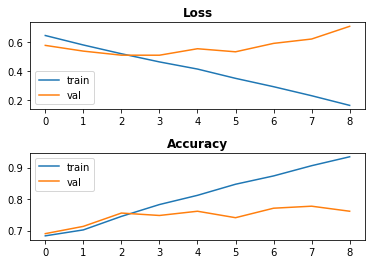



Confusion Matrix, without normalization


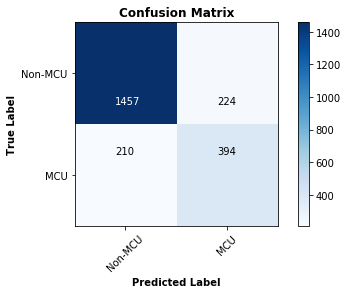



              precision    recall  f1-score   support

     Non-MCU       0.87      0.87      0.87      1681
         MCU       0.64      0.65      0.64       604

    accuracy                           0.81      2285
   macro avg       0.76      0.76      0.76      2285
weighted avg       0.81      0.81      0.81      2285



In [25]:
print(mf.evaluate_test(model_r20_4x4, history_r20_4x4, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

### 5x5

In [26]:
model_r20_5x5 = models.Sequential()
model_r20_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_5x5.add(layers.MaxPooling2D((2, 2)))

model_r20_5x5.add(layers.Flatten())
model_r20_5x5.add(layers.Dense(64, activation='relu'))
model_r20_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r20_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [27]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_5x5 = model_r20_5x5.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 6243 samples, validate on 1559 samples
Epoch 1/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.6199 - acc: 0.6894 - val_loss: 0.5725 - val_acc: 0.6902
Epoch 2/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5856 - acc: 0.6899 - val_loss: 0.5567 - val_acc: 0.6902
Epoch 3/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5534 - acc: 0.7155 - val_loss: 0.5132 - val_acc: 0.7473
Epoch 4/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5187 - acc: 0.7474 - val_loss: 0.4958 - val_acc: 0.7620
Epoch 5/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.4888 - acc: 0.7701 - val_loss: 0.4996 - val_acc: 0.7614
Epoch 6/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.4540 - acc: 0.7905 - val_loss: 0.4882 - val_acc: 0.7646
Epoch 7/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.4159 - acc: 0.8065 - val_loss: 0.4899 - val_acc: 0.7736
Epoch 8/50
624

Accuracy 
 Train: 0.903, Test: 0.811
Loss 
 Train: 0.232, Test: 0.862 



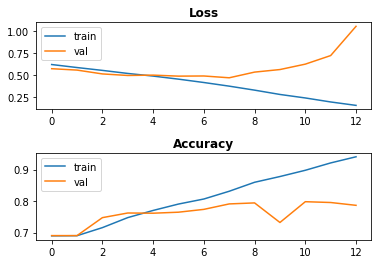



Confusion Matrix, without normalization


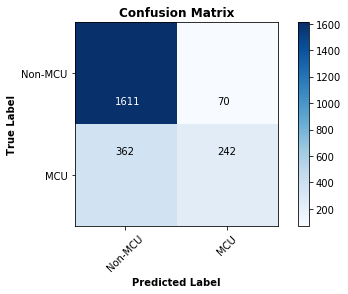



              precision    recall  f1-score   support

     Non-MCU       0.82      0.96      0.88      1681
         MCU       0.78      0.40      0.53       604

    accuracy                           0.81      2285
   macro avg       0.80      0.68      0.71      2285
weighted avg       0.81      0.81      0.79      2285



In [28]:
print(mf.evaluate_test(model_r20_5x5, history_r20_5x5, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

### 6x6

In [29]:
model_r20_6x6 = models.Sequential()
model_r20_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r20_6x6.add(layers.MaxPooling2D((2, 2)))

model_r20_6x6.add(layers.Flatten())
model_r20_6x6.add(layers.Dense(64, activation='relu'))
model_r20_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r20_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [30]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r20_6x6 = model_r20_6x6.fit(train_images_r20,
                                    train_y_r20,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r20, val_y_r20),
                                    callbacks=early_stopping)

Train on 6243 samples, validate on 1559 samples
Epoch 1/50
6243/6243 [==============================] - 10s 2ms/step - loss: 0.6206 - acc: 0.6878 - val_loss: 0.5660 - val_acc: 0.6902
Epoch 2/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.6000 - acc: 0.6899 - val_loss: 0.5566 - val_acc: 0.6902
Epoch 3/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5815 - acc: 0.6893 - val_loss: 0.5585 - val_acc: 0.7081
Epoch 4/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5595 - acc: 0.7146 - val_loss: 0.5402 - val_acc: 0.7396
Epoch 5/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.5187 - acc: 0.7480 - val_loss: 0.5166 - val_acc: 0.7428
Epoch 6/50
6243/6243 [==============================] - 9s 1ms/step - loss: 0.4880 - acc: 0.7700 - val_loss: 0.4936 - val_acc: 0.7736
Epoch 7/50
6243/6243 [==============================] - 8s 1ms/step - loss: 0.4481 - acc: 0.7963 - val_loss: 0.4705 - val_acc: 0.7755
Epoch 8/50
62

Accuracy 
 Train: 0.979, Test: 0.839
Loss 
 Train: 0.061, Test: 0.648 



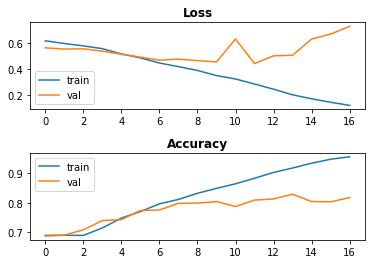



Confusion Matrix, without normalization


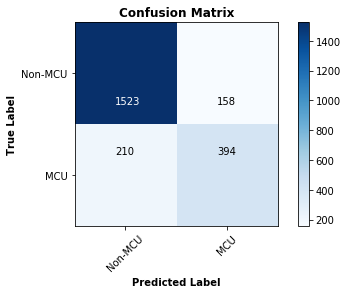



              precision    recall  f1-score   support

     Non-MCU       0.88      0.91      0.89      1681
         MCU       0.71      0.65      0.68       604

    accuracy                           0.84      2285
   macro avg       0.80      0.78      0.79      2285
weighted avg       0.84      0.84      0.84      2285



In [31]:
print(mf.evaluate_test(model_r20_6x6, history_r20_6x6, class_labels, train_images_r20, test_images_r20, train_y_r20, test_y_r20))

# 40% Removal

In [9]:
working_directory = 'mixed_frames_remove_40'

In [10]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 6456 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 4037 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r40 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 5166,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r40 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1290,
    color_mode = 'grayscale',
    subset = 'validation')

Found 5166 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


In [14]:
test_generator_r40 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [15]:
class_labels = ['Non-MCU', 'MCU']
train_images_r40, train_labels_r40 = next(train_generator_r40)
val_images_r40, val_labels_r40 = next(val_generator_r40)
test_images_r40, test_labels_r40 = next(test_generator_r40)
train_y_r40 = np.reshape(train_labels_r40[:,0], (5166,1))
val_y_r40 = np.reshape(val_labels_r40[:,0], (1290,1))
test_y_r40 = np.reshape(test_labels_r40[:,0], (2285,1))
print ("train_images shape: " + str(train_images_r40.shape))
print ("train_labels shape: " + str(train_labels_r40.shape))
print ("val_images shape: " + str(val_images_r40.shape))
print ("val_labels shape: " + str(val_labels_r40.shape))
print ("test_images shape: " + str(test_images_r40.shape))
print ("test_labels shape: " + str(test_labels_r40.shape))

train_images shape: (5166, 128, 128, 1)
train_labels shape: (5166, 2)
val_images shape: (1290, 128, 128, 1)
val_labels shape: (1290, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


In [32]:
model_r40_4x4 = models.Sequential()
model_r40_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_4x4.add(layers.MaxPooling2D((2, 2)))

model_r40_4x4.add(layers.Flatten())
model_r40_4x4.add(layers.Dense(64, activation='relu'))
model_r40_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r40_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [33]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_4x4 = model_r40_4x4.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 5166 samples, validate on 1290 samples
Epoch 1/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6850 - acc: 0.6189 - val_loss: 0.6135 - val_acc: 0.6589
Epoch 2/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6158 - acc: 0.6603 - val_loss: 0.7632 - val_acc: 0.6388
Epoch 3/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5618 - acc: 0.7071 - val_loss: 0.5530 - val_acc: 0.7240
Epoch 4/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5012 - acc: 0.7534 - val_loss: 0.5894 - val_acc: 0.6760
Epoch 5/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.4314 - acc: 0.7983 - val_loss: 0.5413 - val_acc: 0.7442
Epoch 6/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.3792 - acc: 0.8298 - val_loss: 0.5350 - val_acc: 0.7736
Epoch 7/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.3003 - acc: 0.8709 - val_loss: 0.6299 - val_acc: 0.7690
Epoch 8/50
516

Accuracy 
 Train: 0.992, Test: 0.767
Loss 
 Train: 0.030, Test: 1.072 



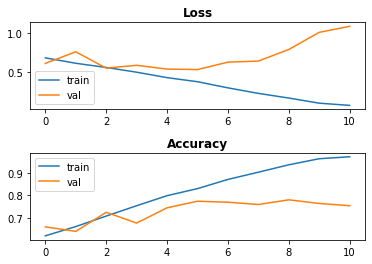



Confusion Matrix, without normalization


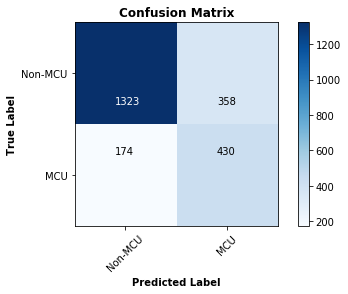



              precision    recall  f1-score   support

     Non-MCU       0.88      0.79      0.83      1681
         MCU       0.55      0.71      0.62       604

    accuracy                           0.77      2285
   macro avg       0.71      0.75      0.73      2285
weighted avg       0.79      0.77      0.78      2285



In [34]:
print(mf.evaluate_test(model_r40_4x4, history_r40_4x4, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

### 5x5

In [35]:
model_r40_5x5 = models.Sequential()
model_r40_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_5x5.add(layers.MaxPooling2D((2, 2)))

model_r40_5x5.add(layers.Flatten())
model_r40_5x5.add(layers.Dense(64, activation='relu'))
model_r40_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r40_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [36]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_5x5 = model_r40_5x5.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 5166 samples, validate on 1290 samples
Epoch 1/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6651 - acc: 0.6237 - val_loss: 0.6604 - val_acc: 0.6256
Epoch 2/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6357 - acc: 0.6262 - val_loss: 0.5867 - val_acc: 0.6333
Epoch 3/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6137 - acc: 0.6500 - val_loss: 0.5630 - val_acc: 0.7101
Epoch 4/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5710 - acc: 0.6994 - val_loss: 0.5705 - val_acc: 0.7341
Epoch 5/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5290 - acc: 0.7342 - val_loss: 0.5025 - val_acc: 0.7744
Epoch 6/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.4878 - acc: 0.7638 - val_loss: 0.5663 - val_acc: 0.7116
Epoch 7/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.4461 - acc: 0.7915 - val_loss: 0.5285 - val_acc: 0.7465
Epoch 8/50
516

Accuracy 
 Train: 0.932, Test: 0.818
Loss 
 Train: 0.172, Test: 0.633 



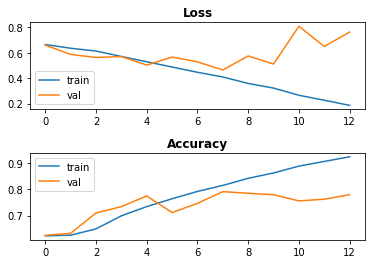



Confusion Matrix, without normalization


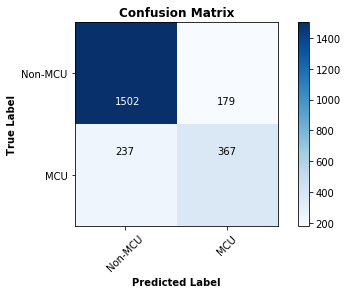



              precision    recall  f1-score   support

     Non-MCU       0.86      0.89      0.88      1681
         MCU       0.67      0.61      0.64       604

    accuracy                           0.82      2285
   macro avg       0.77      0.75      0.76      2285
weighted avg       0.81      0.82      0.81      2285



In [37]:
print(mf.evaluate_test(model_r40_5x5, history_r40_5x5, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

### 6x6

In [38]:
model_r40_6x6 = models.Sequential()
model_r40_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r40_6x6.add(layers.MaxPooling2D((2, 2)))

model_r40_6x6.add(layers.Flatten())
model_r40_6x6.add(layers.Dense(64, activation='relu'))
model_r40_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r40_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [39]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r40_6x6 = model_r40_6x6.fit(train_images_r40,
                                    train_y_r40,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r40, val_y_r40),
                                    callbacks=early_stopping)

Train on 5166 samples, validate on 1290 samples
Epoch 1/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6527 - acc: 0.6227 - val_loss: 0.6124 - val_acc: 0.6256
Epoch 2/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6318 - acc: 0.6262 - val_loss: 0.6015 - val_acc: 0.7101
Epoch 3/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6115 - acc: 0.6620 - val_loss: 0.6059 - val_acc: 0.6450
Epoch 4/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5857 - acc: 0.6823 - val_loss: 0.5971 - val_acc: 0.6783
Epoch 5/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5572 - acc: 0.7166 - val_loss: 0.5523 - val_acc: 0.7163
Epoch 6/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5265 - acc: 0.7365 - val_loss: 0.5620 - val_acc: 0.6922
Epoch 7/50
5166/5166 [==============================] - 7s 1ms/step - loss: 0.5001 - acc: 0.7602 - val_loss: 0.5317 - val_acc: 0.7341
Epoch 8/50
516

Accuracy 
 Train: 0.900, Test: 0.794
Loss 
 Train: 0.238, Test: 0.509 



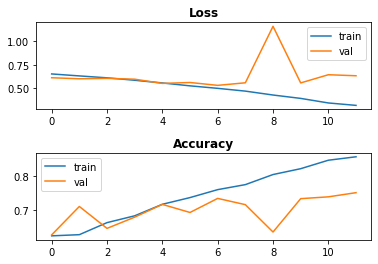



Confusion Matrix, without normalization


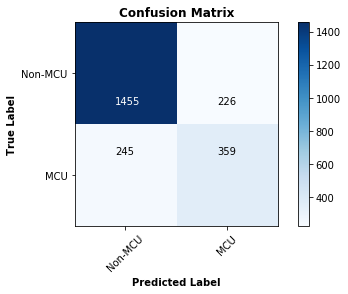



              precision    recall  f1-score   support

     Non-MCU       0.86      0.87      0.86      1681
         MCU       0.61      0.59      0.60       604

    accuracy                           0.79      2285
   macro avg       0.73      0.73      0.73      2285
weighted avg       0.79      0.79      0.79      2285



In [40]:
print(mf.evaluate_test(model_r40_6x6, history_r40_6x6, class_labels, train_images_r40, test_images_r40, train_y_r40, test_y_r40))

# 60% Removal

In [16]:
working_directory = 'mixed_frames_remove_60'

In [17]:
train_folder = os.path.join('mcu_data', working_directory, 'train')
train_mcu = os.path.join(train_folder, 'mcu')
train_non = os.path.join(train_folder, 'non_mcu')

test_folder = os.path.join('mcu_data', working_directory, 'test')
test_mcu = os.path.join(test_folder, 'mcu')
test_non = os.path.join(test_folder, 'non_mcu')

print('There are', len(os.listdir(train_mcu)) + len(os.listdir(train_non)), 'images in the Train set')
print('There are', len(os.listdir(test_mcu)) + len(os.listdir(test_non)), 'images in the Test set')

print('\n')

print('There are', len(os.listdir(train_mcu)), 'MCU images in the train set')
print('There are', len(os.listdir(train_non)), 'non-MCU images in the train set')
print('There are', len(os.listdir(test_mcu)), 'MCU images in the test set')
print('There are', len(os.listdir(test_non)), 'non-MCU images in the test set')

There are 5111 images in the Train set
There are 2285 images in the Test set


There are 2419 MCU images in the train set
There are 2692 non-MCU images in the train set
There are 604 MCU images in the test set
There are 1681 non-MCU images in the test set


### Create input data with image size of 128 x 128

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_r60 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 4090,
    color_mode = 'grayscale',
    subset = 'training')

val_generator_r60 = train_datagen.flow_from_directory(
    train_folder,
    target_size = (128, 128),
    batch_size = 1021,
    color_mode = 'grayscale',
    subset = 'validation')

Found 4090 images belonging to 2 classes.
Found 1021 images belonging to 2 classes.


In [21]:
test_generator_r60 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 2285)

Found 2285 images belonging to 2 classes.


In [22]:
class_labels = ['Non-MCU', 'MCU']
train_images_r60, train_labels_r60 = next(train_generator_r60)
val_images_r60, val_labels_r60 = next(val_generator_r60)
test_images_r60, test_labels_r60 = next(test_generator_r60)
train_y_r60 = np.reshape(train_labels_r60[:,0], (4090,1))
val_y_r60 = np.reshape(val_labels_r60[:,0], (1021,1))
test_y_r60 = np.reshape(test_labels_r60[:,0], (2285,1))
print ("train_images shape: " + str(train_images_r60.shape))
print ("train_labels shape: " + str(train_labels_r60.shape))
print ("val_images shape: " + str(val_images_r60.shape))
print ("val_labels shape: " + str(val_labels_r60.shape))
print ("test_images shape: " + str(test_images_r60.shape))
print ("test_labels shape: " + str(test_labels_r60.shape))

train_images shape: (4090, 128, 128, 1)
train_labels shape: (4090, 2)
val_images shape: (1021, 128, 128, 1)
val_labels shape: (1021, 2)
test_images shape: (2285, 128, 128, 1)
test_labels shape: (2285, 2)


In [41]:
model_r60_4x4 = models.Sequential()
model_r60_4x4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_4x4.add(layers.MaxPooling2D((2, 2)))

model_r60_4x4.add(layers.Flatten())
model_r60_4x4.add(layers.Dense(64, activation='relu'))
model_r60_4x4.add(layers.Dense(1, activation='sigmoid'))

model_r60_4x4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [42]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_4x4 = model_r60_4x4.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6971 - acc: 0.5325 - val_loss: 0.6671 - val_acc: 0.5955
Epoch 2/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6518 - acc: 0.6117 - val_loss: 0.6295 - val_acc: 0.6709
Epoch 3/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6273 - acc: 0.6579 - val_loss: 0.6417 - val_acc: 0.6210
Epoch 4/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5646 - acc: 0.7034 - val_loss: 0.5909 - val_acc: 0.6690
Epoch 5/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.5191 - acc: 0.7413 - val_loss: 0.5715 - val_acc: 0.6934
Epoch 6/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.4563 - acc: 0.7802 - val_loss: 0.5786 - val_acc: 0.7120
Epoch 7/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.3976 - acc: 0.8222 - val_loss: 0.5613 - val_acc: 0.7326
Epoch 8/50
409

Accuracy 
 Train: 0.976, Test: 0.710
Loss 
 Train: 0.075, Test: 1.113 



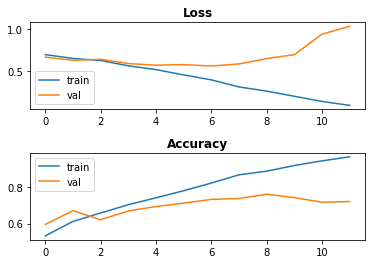



Confusion Matrix, without normalization


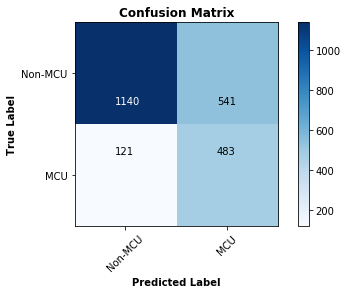



              precision    recall  f1-score   support

     Non-MCU       0.90      0.68      0.77      1681
         MCU       0.47      0.80      0.59       604

    accuracy                           0.71      2285
   macro avg       0.69      0.74      0.68      2285
weighted avg       0.79      0.71      0.73      2285



In [43]:
print(mf.evaluate_test(model_r60_4x4, history_r60_4x4, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))

### 5x5

In [44]:
model_r60_5x5 = models.Sequential()
model_r60_5x5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_5x5.add(layers.MaxPooling2D((2, 2)))

model_r60_5x5.add(layers.Flatten())
model_r60_5x5.add(layers.Dense(64, activation='relu'))
model_r60_5x5.add(layers.Dense(1, activation='sigmoid'))

model_r60_5x5.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [45]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_5x5 = model_r60_5x5.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.6913 - acc: 0.5557 - val_loss: 0.6477 - val_acc: 0.5651
Epoch 2/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6649 - acc: 0.6108 - val_loss: 0.6334 - val_acc: 0.6464
Epoch 3/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6461 - acc: 0.6254 - val_loss: 0.6242 - val_acc: 0.6082
Epoch 4/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6155 - acc: 0.6665 - val_loss: 0.5809 - val_acc: 0.7267
Epoch 5/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.5813 - acc: 0.7034 - val_loss: 0.5611 - val_acc: 0.7023
Epoch 6/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.5395 - acc: 0.7355 - val_loss: 0.5789 - val_acc: 0.6895
Epoch 7/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.5040 - acc: 0.7655 - val_loss: 0.5331 - val_acc: 0.7453
Epoch 8/50
409

Accuracy 
 Train: 0.966, Test: 0.743
Loss 
 Train: 0.107, Test: 0.690 



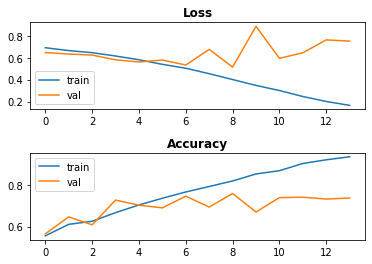



Confusion Matrix, without normalization


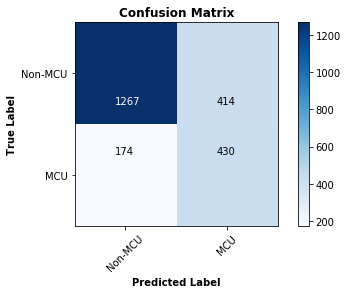



              precision    recall  f1-score   support

     Non-MCU       0.88      0.75      0.81      1681
         MCU       0.51      0.71      0.59       604

    accuracy                           0.74      2285
   macro avg       0.69      0.73      0.70      2285
weighted avg       0.78      0.74      0.75      2285



In [46]:
print(mf.evaluate_test(model_r60_5x5, history_r60_5x5, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))

### 6x6

In [47]:
model_r60_6x6 = models.Sequential()
model_r60_6x6.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_r60_6x6.add(layers.MaxPooling2D((2, 2)))

model_r60_6x6.add(layers.Flatten())
model_r60_6x6.add(layers.Dense(64, activation='relu'))
model_r60_6x6.add(layers.Dense(1, activation='sigmoid'))

model_r60_6x6.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [48]:
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history_r60_6x6 = model_r60_6x6.fit(train_images_r60,
                                    train_y_r60,
                                    epochs=50,
                                    batch_size=50,
                                    validation_data=(val_images_r60, val_y_r60),
                                    callbacks=early_stopping)

Train on 4090 samples, validate on 1021 samples
Epoch 1/50
4090/4090 [==============================] - 6s 1ms/step - loss: 0.7025 - acc: 0.5413 - val_loss: 0.6679 - val_acc: 0.6308
Epoch 2/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6718 - acc: 0.5883 - val_loss: 0.6583 - val_acc: 0.5230
Epoch 3/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6550 - acc: 0.6215 - val_loss: 0.6488 - val_acc: 0.6190
Epoch 4/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6428 - acc: 0.6377 - val_loss: 0.5773 - val_acc: 0.7218
Epoch 5/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.6180 - acc: 0.6724 - val_loss: 0.5900 - val_acc: 0.7120
Epoch 6/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.5921 - acc: 0.6988 - val_loss: 0.5887 - val_acc: 0.7130
Epoch 7/50
4090/4090 [==============================] - 5s 1ms/step - loss: 0.5563 - acc: 0.7254 - val_loss: 0.5510 - val_acc: 0.7453
Epoch 8/50
409

Accuracy 
 Train: 0.959, Test: 0.737
Loss 
 Train: 0.132, Test: 0.687 



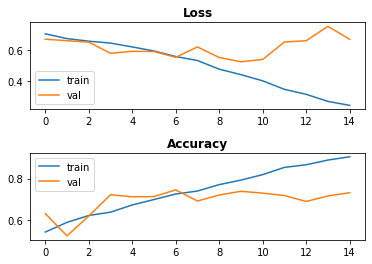



Confusion Matrix, without normalization


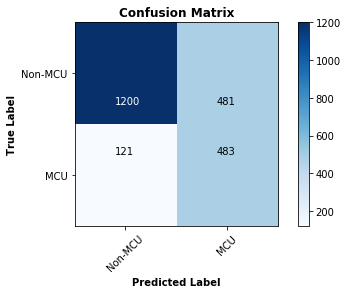



              precision    recall  f1-score   support

     Non-MCU       0.91      0.71      0.80      1681
         MCU       0.50      0.80      0.62       604

    accuracy                           0.74      2285
   macro avg       0.70      0.76      0.71      2285
weighted avg       0.80      0.74      0.75      2285



In [49]:
print(mf.evaluate_test(model_r60_6x6, history_r60_6x6, class_labels, train_images_r60, test_images_r60, train_y_r60, test_y_r60))

In [50]:
model_r60_6x6.save('saved_models/baseline_r60_6x6')